In [13]:
import rasterio as rio
import yaml
from s2flow.models import get_sr_model
from s2flow.engine.sampling import BaseSampler
from s2flow.data.utils import scale
from s2flow.utils import get_device
import torch
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import font_manager
import geopandas as gpd
import os

font_path = '/home/dhester/.fonts/InterVariable.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

In [56]:
class AdjusterMidpointSampler(BaseSampler):
    def __init__(self, num_steps: int, model: torch.nn.Module):
        
        config = {}
        # use amp
        config['hyperparameters'] = {'use_amp': True} 
        config['sampling'] = {'num_steps': num_steps}
        torch.manual_seed(0) # for reproducibility
        self.init_x = torch.randn(4, 256, 256)
        super().__init__(config, model)
        
    
    @torch.no_grad()
    def sample(self, cond: torch.Tensor) -> torch.Tensor:
        out = []
        x = torch.Tensor.repeat(self.init_x, cond.shape[0], 1, 1, 1).to(self.device)
        out.append(x.cpu())
        for t in tqdm(self.timesteps, desc="Sampling", leave=False, unit="step"):
            t_batch = torch.ones(cond.shape[0], device=self.device) * t
            t_mid_batch = torch.ones(cond.shape[0], device=self.device) * (t + (self.step_size / 2))
            
            # Compute velocity at the start of the step
            model_input = torch.cat((x, cond), dim=1)
            with self.autocast_context:
                v1 = self.model(model_input, t_batch * 1000)
            
            # Estimate midpoint
            x_mid = x + v1 * (self.step_size / 2)
            model_input_mid = torch.cat((x_mid, cond), dim=1)
            with self.autocast_context:
                v2 = self.model(model_input_mid, t_mid_batch * 1000)
            
            x = x + v2 * self.step_size
            out.append(x.cpu())
        
        return torch.stack(out, dim=1)

In [6]:
config = yaml.safe_load(open('../configs/s2flow-sreval.yaml', 'r'))
model = get_sr_model(config['sr_model'])
model.load_state_dict(torch.load('../runs/s2flow_sr_train/model.pt'))

sampler = AdjusterMidpointSampler(20, model)

files = glob('../data/s2flow-s2naip/sentinel2/*.tif')
naip_files = [f.replace('sentinel2', 'naip') for f in files]

# with rio.open('../data/s2flow-s2naip/sentinel2/

In [5]:

selected_file_idxs = [15, 64, 70, 78]

s2_batch = []
naip_batch = []
for file_idx in selected_file_idxs:
    with rio.open(files[file_idx]) as src_s2:
        s2 = src_s2.read()
    s2 = torch.from_numpy(s2).to(torch.float32)
    s2 = scale(s2, in_range=(0, 10000), out_range=(-1, 1))
    naip_img = rio.open(naip_files[file_idx]).read()
    s2_batch.append(s2)
    naip_batch.append(naip_img)

s2_batch = torch.stack(s2_batch, dim=0).to(sampler.device)

outs = sampler.sample(s2_batch)  # add batch dimension
# outs_tensor = 
s2_batch = s2_batch.cpu()

fig, axes = plt.subplots(len(selected_file_idxs), 7, figsize=(17, 10))
gain = 2.8

for ax, s2, out, naip in zip(axes, s2_batch, outs, naip_batch):

    # s2_unscaled = scale(s2, in_range=(-1, 1), out_range=(0, 1))
    # s2_unscaled = s2_unscaled.permute(1, 2, 0).numpy() * gain
    img = scale(s2, in_range=(-1, 1), out_range=(0, 1)) * gain
    img = img.permute(1, 2, 0)[:, :, :3]
    img = img.clamp(0, 1)
    ax[0].imshow(img)
    # ax[0].set_title('Sentinel-2 Input', fontsize=16)
    ax[0].axis('off')

    # out_unscaled = scale(out[int(0*sampler.num_timesteps)], in_range=(-1, 1), out_range=(0, 1))
    # out_unscaled = out_unscaled.permute(1, 2, 0) * gain
    img = scale(out[int(0*sampler.num_timesteps)], in_range=(-1, 1), out_range=(0, 1)) * gain
    img = img.permute(1, 2, 0)[:, :, :3]
    img = img.clamp(0, 1)
    ax[1].imshow(img)
    # ax[1].set_title('$t=0$', fontsize=16)
    ax[1].axis('off')

    # out_unscaled = scale(out[int(.25*sampler.num_timesteps)], in_range=(-1, 1), out_range=(0, 1))
    # out_unscaled = out_unscaled.permute(1, 2, 0) * gain
    img = scale(out[int(.25*sampler.num_timesteps)], in_range=(-1, 1), out_range=(0, 1)) * gain
    img = img.permute(1, 2, 0)[:, :, :3]
    img = img.clamp(0, 1)
    ax[2].imshow(img)
    # ax[2].set_title('$t=.25$', fontsize=16)
    ax[2].axis('off')

    # out_unscaled = scale(out[int(.5*sampler.num_timesteps)], in_range=(-1, 1), out_range=(0, 1))
    # out_unscaled = out_unscaled.permute(1, 2, 0) * gain
    img = scale(out[int(.5*sampler.num_timesteps)], in_range=(-1, 1), out_range=(0, 1)) * gain
    img = img.permute(1, 2, 0)[:, :, :3]
    img = img.clamp(0, 1)
    ax[3].imshow(img)
    # ax[3].set_title('$t=.5$', fontsize=16)
    ax[3].axis('off')

    img = scale(out[int(.75*sampler.num_timesteps)], in_range=(-1, 1), out_range=(0, 1)) * gain
    img = img.permute(1, 2, 0)[:, :, :3]
    img = img.clamp(0, 1)
    ax[4].imshow(img)
    # ax[4].set_title('$t=.75$', fontsize=16)
    ax[4].axis('off')

    img = scale(out[-1], in_range=(-1, 1), out_range=(0, 1)) * gain
    img = img.permute(1, 2, 0)[:, :, :3]
    img = img.clamp(0, 1)
    # print(img.shape, img.min(), img.max())
    ax[5].imshow(img)
    # ax[5].set_title('$t=1$', fontsize=16)
    ax[5].axis('off')

    img = scale(torch.from_numpy(naip).to(torch.float32), in_range=(0, 10000), out_range=(0, 1)) * gain
    img = img.permute(1, 2, 0)[:, :, :3]
    img = img.clamp(0, 1)
    ax[6].imshow(img)
    # ax[6].set_title('Ground Truth', fontsize=16)
    ax[6].axis('off')
    
# plt.suptitle(file_idx)

axes[0][0].set_title('Sentinel-2 Input', fontsize=20)
axes[0][1].set_title('$t=0$', fontsize=20)
axes[0][2].set_title('$t=0.25$', fontsize=20)
axes[0][3].set_title('$t=0.5$', fontsize=20)
axes[0][4].set_title('$t=0.75$', fontsize=20)
axes[0][5].set_title('$t=1$', fontsize=20)
axes[0][6].set_title('NAIP Reference', fontsize=20)

fig.tight_layout()

# reduce space between subplots
fig.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

for fileex in ('.png', '.pdf'):
    fig.savefig(f'../runs/s2flow_sr_eval_steps/sr_flow_matching_ex_20steps{fileex}', bbox_inches='tight', dpi=300 if fileex=='.png' else None)

NameError: name 'files' is not defined

In [ ]:
gain = 3

samples_gdf = gpd.read_parquet('../data/s2flow-s2naip/samples.par')
samples_gdf = samples_gdf.loc[samples_gdf['split']=='val'].reset_index()

for idx in range(150, 200):
    naip_img_path = samples_gdf['target_path'].iloc[idx]
    naip_img_path = os.path.join('../data/s2flow-s2naip', naip_img_path)
    
    naip_img = rio.open(naip_img_path).read()
    img = scale(torch.from_numpy(naip_img).to(torch.float32), in_range=(0, 10000), out_range=(0, 1)) * gain
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(img.permute(1, 2, 0)[:, :, :3].clamp(0,1))
    ax.axis('off')
    ax.set_title(f'NAIP Image Index {idx}', fontsize=20)
    plt.show()

In [57]:
# show effect of varying number of steps
step_nums = [1, 10, 20, 30, 40]

# selected_file_idxs = [61, 70, 126, 147]
selected_file_idxs = [15, 49, 70, 117, 170, 188]

s2_batch = []
naip_batch = []
for file_idx in selected_file_idxs:
    
    naip_img_path = samples_gdf['target_path'].iloc[file_idx]
    naip_img_path = os.path.join('../data/s2flow-s2naip', naip_img_path)
    
    s2_img_path = samples_gdf['input_path'].iloc[file_idx]
    s2_img_path = os.path.join('../data/s2flow-s2naip', s2_img_path)
    
    with rio.open(s2_img_path) as src_s2:
        s2 = src_s2.read()
    s2 = torch.from_numpy(s2).to(torch.float32)
    s2 = scale(s2, in_range=(0, 10000), out_range=(-1, 1))
    naip_img = rio.open(naip_img_path).read()
    s2_batch.append(s2)
    naip_batch.append(naip_img)
s2_batch = torch.stack(s2_batch, dim=0).to(sampler.device)

steps_dict = {}
for step_num in step_nums:
    outs = AdjusterMidpointSampler(step_num, model).sample(s2_batch)
    steps_dict[step_num] = outs.cpu()[:, -1]  # only keep final output


torch.Size([128, 128, 3])
torch.Size([128, 128, 3])
torch.Size([128, 128, 3])
torch.Size([128, 128, 3])
torch.Size([128, 128, 3])
torch.Size([128, 128, 3])


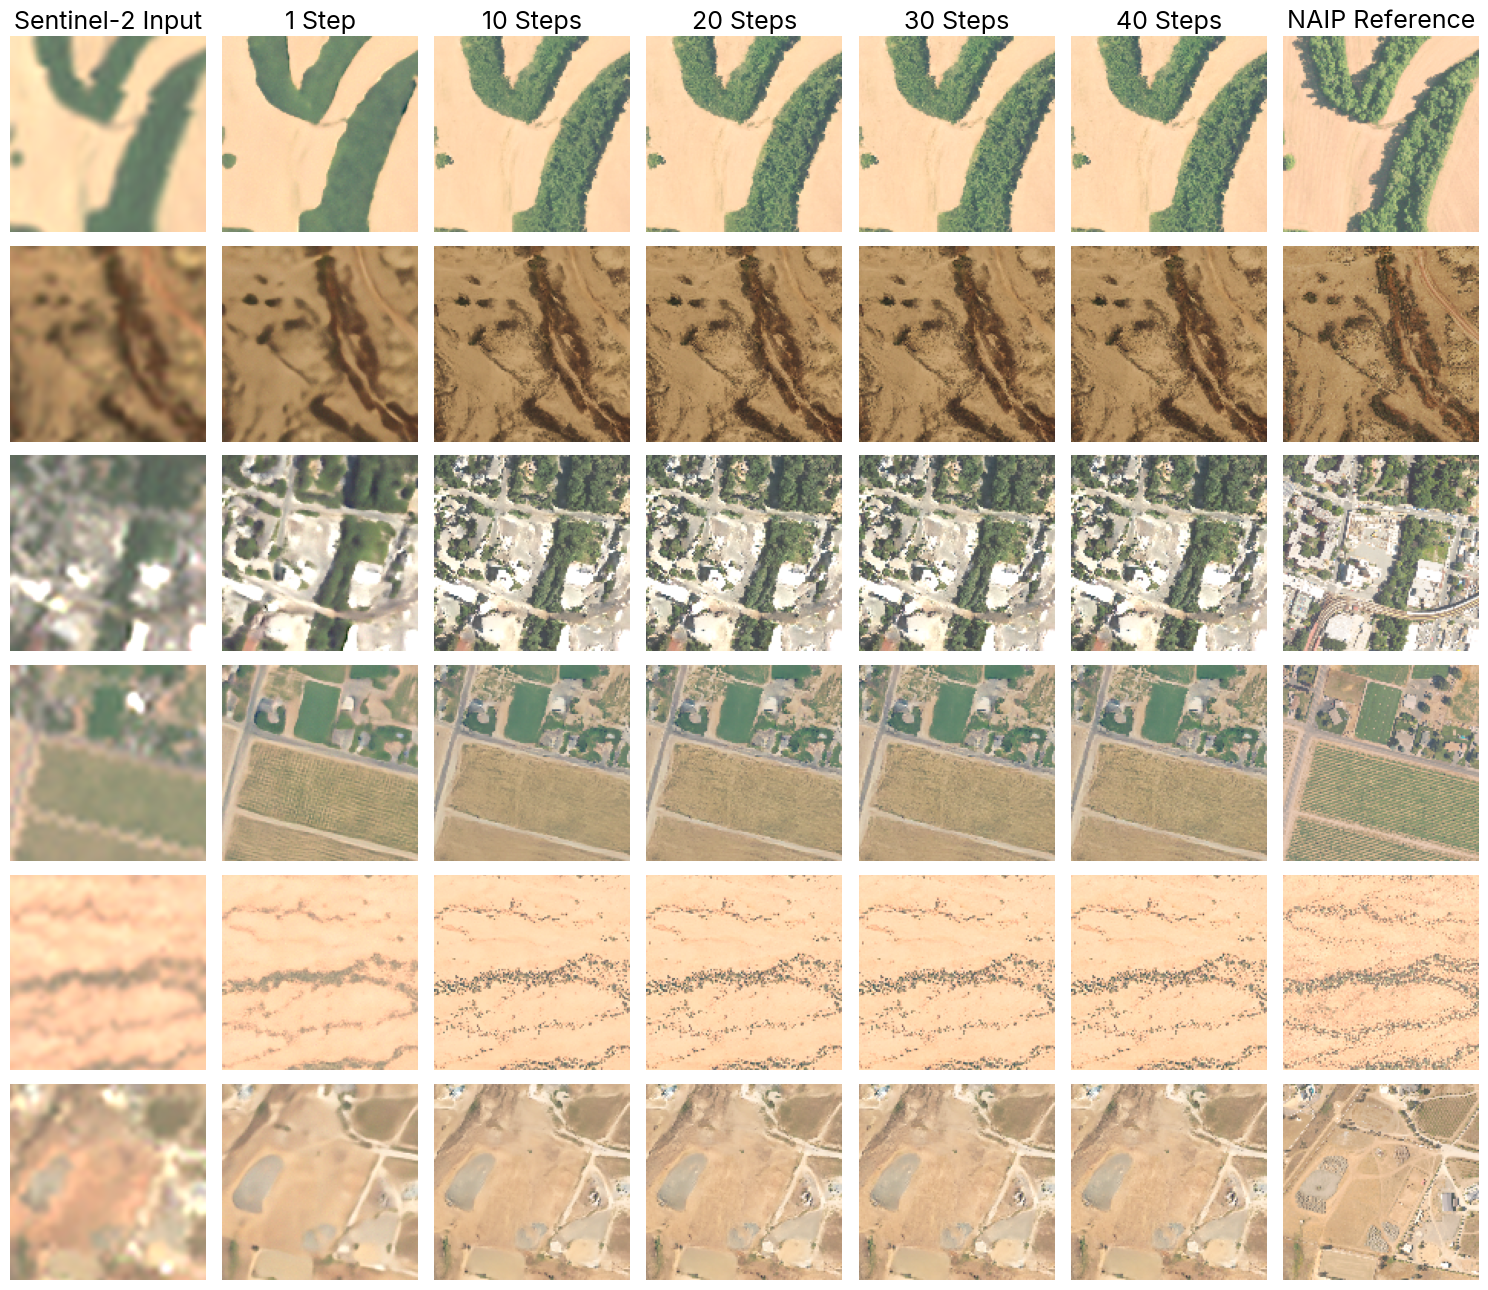

In [ ]:
fig, ax = plt.subplots(len(selected_file_idxs), len(step_nums)+2, figsize=(15, 13))
gain = 3

for i, (a, s2, naip) in enumerate(zip(ax, s2_batch, naip_batch)):
    
    img = scale(s2.cpu(), in_range=(-1, 1), out_range=(0, 1)) * gain
    img = img.permute(1, 2, 0)[:, :, :3]
    img = img.clamp(0, 1)
    img = img[64:-64, 64:-64, :]
    a[0].imshow(img)
    a[0].axis('off')

    for j, step_num in enumerate(step_nums):
        out = steps_dict[step_num][i]
        img = scale(out, in_range=(-1, 1), out_range=(0, 1)) * gain
        img = img.permute(1, 2, 0)[:, :, :3]
        img = img.clamp(0, 1)
        # keep only bottom right corner of image 
        img = img[64:-64, 64:-64, :]
        a[j+1].imshow(img)
        a[j+1].axis('off')

    img = scale(torch.from_numpy(naip).to(torch.float32), in_range=(0, 10000), out_range=(0, 1)) * gain
    img = img.permute(1, 2, 0)[:, :, :3]
    img = img.clamp(0, 1)
    img = img[64:-64, 64:-64, :]
    a[-1].imshow(img)
    a[-1].axis('off')

ax[0][0].set_title('Sentinel-2 Input', fontsize=18)
ax[0][1].set_title('1 Step', fontsize=18)
ax[0][2].set_title('10 Steps', fontsize=18)
ax[0][3].set_title('20 Steps', fontsize=18)
ax[0][4].set_title('30 Steps', fontsize=18)
ax[0][5].set_title('40 Steps', fontsize=18)
ax[0][-1].set_title('NAIP Reference', fontsize=18)
fig.tight_layout()

for fileex in ('.png', '.pdf'):
    fig.savefig(f'../runs/s2flow_sr_eval_steps/sr_flow_matching_ex_varyingsteps{fileex}', bbox_inches='tight', dpi=300 if fileex=='.png' else None)